# Impact of Scattered Moonlight on Exposure Times

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import os.path

In [3]:
import astropy.table
import astropy.constants
import astropy.units as u

In [4]:
import sklearn.linear_model

## Simulation Config

In [5]:
import specsim.simulator

In [6]:
desi = specsim.simulator.Simulator('desi')

## ELG Fiducial Target

Look up the expected redshift distribution of ELG targets.  Note that the ELG doublet falls off the spectrograph around z = 1.63.

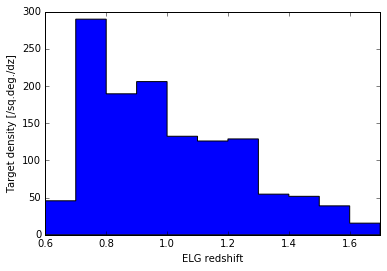

In [7]:
def get_elg_nz(plot=True):
    
    # Read the nz file from $DESIMODEL.
    full_name = os.path.join(os.environ['DESIMODEL'], 'data', 'targets', 'nz_elg.dat')
    table = astropy.table.Table.read(full_name, format='ascii')

    # Extract the n(z) histogram into numpy arrays.
    z_lo, z_hi = table['col1'], table['col2']
    assert np.all(z_hi[:-1] == z_lo[1:])
    z_edge = np.hstack((z_lo, [z_hi[-1]]))
    nz = table['col3']
    
    # Trim to bins where n(z) > 0.
    non_zero = np.where(nz > 0)[0]
    lo, hi = non_zero[0], non_zero[-1] + 1
    nz = nz[lo: hi]
    z_edge = z_edge[lo: hi + 1]

    if plot:
        plt.hist(0.5 * (z_edge[1:] + z_edge[:-1]), weights=nz, bins=z_edge, histtype='stepfilled')
        plt.xlabel('ELG redshift')
        plt.ylabel('Target density [/sq.deg./dz]')
        plt.xlim(z_edge[0], z_edge[-1])
        
    return nz, z_edge
    
nz, z_edge = get_elg_nz()

Generate a random sample of redshifts from this distribution:

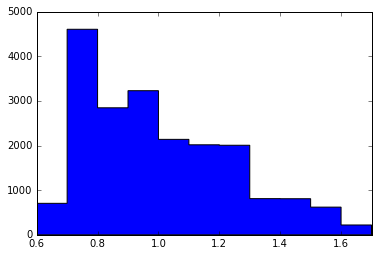

In [8]:
def generate_elg_z(n=100, seed=123):
    cdf = np.cumsum(nz)
    cdf = np.hstack(([0], cdf / cdf[-1]))
    gen = np.random.RandomState(seed)
    return np.interp(gen.rand(n), cdf, z_edge)
    
plt.hist(generate_elg_z(n=20000), bins=z_edge, histtype='stepfilled')
plt.xlim(z_edge[0], z_edge[-1]);

Define a canonical set of 50 ELG redshifts to use for SNR calculations:

In [9]:
z_elg_ref = generate_elg_z(n=50, seed=123)

Generate a rest-frame doublet spectrum using the specified parameter values:

In [10]:
CLIGHT_KM_S = astropy.constants.c.to(u.km / u.s).value

In [11]:
def oii_doublet(wlen, total_flux=8e-17, peak1_wlen=3727.092, peak2_wlen=3729.874, flux_ratio12=0.73, sigma_v=75.):
    log10 = np.log(10)
    sigma_log10_wlen = sigma_v / CLIGHT_KM_S / log10
    log10_wlen = np.log10(wlen)
    flux1 = total_flux * flux_ratio12 / (1 + flux_ratio12)
    flux2 = total_flux / (1 + flux_ratio12)
    denom = np.sqrt(2 * np.pi) * sigma_log10_wlen
    amp1 = flux1 / peak1_wlen / log10 / denom
    amp2 = flux2 / peak2_wlen / log10 / denom
    flux = (
        amp1 * np.exp(-0.5 * ((log10_wlen - np.log10(peak1_wlen)) / sigma_log10_wlen)**2) +
        amp2 * np.exp(-0.5 * ((log10_wlen - np.log10(peak2_wlen)) / sigma_log10_wlen)**2))
    return flux

The default parameter values define the fiducial ELG target.  Add zero padding so we cover the full spectrograph at any redshift.

In [12]:
elg_wlen0 = np.hstack(([1000], np.linspace(3723., 3734., 50), [11000]))
elg_flux0 = oii_doublet(elg_wlen0)

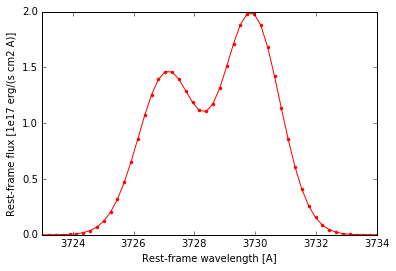

In [13]:
def plot_fiducial_elg():
    plt.plot(elg_wlen0, 1e17 * elg_flux0, 'r.-')
    plt.xlim(elg_wlen0[1], elg_wlen0[-2])
    plt.xlabel('Rest-frame wavelength [A]')
    plt.ylabel('Rest-frame flux [1e17 erg/(s cm2 A)]')
    
plot_fiducial_elg()

Configure the simulator to use this rest-frame spectrum:

In [15]:
desi.source.update_in(
    'ELG [OII] doublet', 'elg',
    elg_wlen0 * u.Angstrom, elg_flux0 * u.erg/(u.cm**2 * u.s * u.Angstrom), z_in=0.)

Simulate the nominal ELG target given a redshift (or list of redshifts) and observing conditions, and calculate the total [OII] SNR:

In [16]:
def simulate_elg(z, exposure_time=1000*u.s, airmass=1.0, simulator=desi,
                 moon_phase=0.25, moon_zenith=100*u.deg, moon_separation=60*u.deg):
    
    # Configure the simulation.
    simulator.observation.exposure_time = exposure_time
    simulator.atmosphere.airmass = airmass
    simulator.atmosphere.moon.moon_phase = moon_phase
    simulator.atmosphere.moon.moon_zenith = moon_zenith
    simulator.atmosphere.moon.separation_angle = moon_separation
    
    # z can either be a scalar or an array.
    z = np.asarray(z)
    if z.shape == ():
        is_scalar = True
        z = [z]
    else:
        is_scalar = False
    snr_sum_sq = np.zeros_like(z)

    for i, z_elg in enumerate(z):
        simulator.source.update_out(z_out=z_elg)
        simulator.simulate()

        # Integrate the SNR over all three cameras.
        for camera in simulator.camera_output:
            snr = camera['observed_flux'] * np.sqrt(camera['flux_inverse_variance'])
            snr_sum_sq[i] += np.sum(snr ** 2)

    snr_tot = np.sqrt(snr_sum_sq)
    return snr_tot[0] if is_scalar else snr_tot

Calculate the nominal (dark-time, airmass 1) SNR for each of the reference redshifts:

In [16]:
snr_elg_ref = simulate_elg(z_elg_ref)

Calculate the SNR for specified observing conditions and use these to calculate the exposure time correction assuming that:
$$
t_{moon} / t_{dark} = \sqrt{\nu_{dark}/\nu_{moon}} \; .
$$
Also returns the scattered moon V-band magnitude.

CPU times: user 1.81 s, sys: 6.5 ms, total: 1.82 s
Wall time: 1.82 s


(1.2228997646232895, <Quantity 19.88746107576404 mag / arcsec2>)

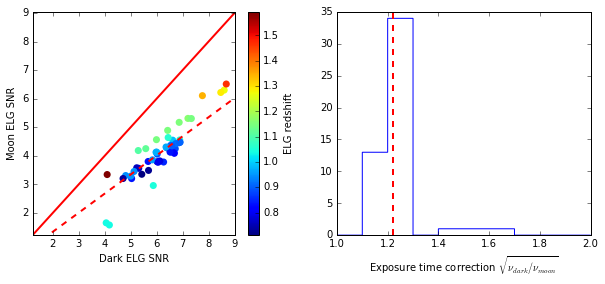

In [60]:
def get_elg_exposure_factor(**kwargs):
    
    plot = kwargs.get('plot', None)
    if plot:
        del kwargs['plot']
    
    snr = simulate_elg(z_elg_ref, exposure_time=1000*u.s, **kwargs)
    moon_V = desi.atmosphere.moon.scattered_V
    ratio = np.sqrt(snr_elg_ref / snr)
    factor = np.median(ratio)
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        lo, hi = np.min(snr), np.max(snr_elg_ref)
        pad = 0.05 * (hi - lo)
        lo -= pad
        hi += pad
        s = ax[0].scatter(snr_elg_ref, snr, c=z_elg_ref, lw=0, s=50)
        plt.colorbar(s, ax=ax[0]).set_label('ELG redshift')
        ax[0].plot([lo, hi], [lo, hi], 'r-', lw=2)
        ax[0].plot([lo, hi], [lo / factor ** 2, hi / factor ** 2], 'r-', lw=2, ls='--')
        ax[0].set_xlim(lo, hi)
        ax[0].set_ylim(lo, hi)
        ax[0].set_xlabel('Dark ELG SNR')
        ax[0].set_ylabel('Moon ELG SNR')

        ax[1].hist(ratio, range=(1, 2), bins=10, histtype='step')
        ax[1].axvline(factor, ls='--', color='r', lw=2)
        ax[1].set_xlabel('Exposure time correction $\sqrt{\\nu_{dark}/\\nu_{moon}}$')
        ax[1].set_xlim(1, 2)
    
    return factor, moon_V
    
%time get_elg_exposure_factor(moon_zenith=20*u.deg, moon_separation=60*u.deg, plot=True)

Calculate correction factors for a range of moon conditions, and verify that only the V-band magnitude is needed:

In [59]:
def run_moon_study(n=500, seed=123):

    gen = np.random.RandomState(seed)
    
    # Generate random zenith moon parameters, with a bias towards
    # lots of scattered moonlight.
    moon_separation = gen.uniform(0, 60, n) * u.deg
    moon_phase = gen.uniform(0, 0.8, n) * u.deg
    
    factor = np.empty(n)
    moon_V = np.empty(n)
    for i, (s, p) in enumerate(zip(moon_separation, moon_phase)):
        factor[i], V = get_elg_exposure_factor(moon_zenith=10*u.deg, moon_separation=s, moon_phase=p)
        moon_V[i] = V.value
        if i % 50 == 0:
            print i, (s, p), factor[i], moon_V[i]

    return moon_V, factor
    
%time moon_V, factor = run_moon_study()

0 (<Quantity 41.7881511358717 deg>, <Quantity 0.17026519885531927 deg>) 1.37038104522 19.0959449171
50 (<Quantity 7.237719959419424 deg>, <Quantity 0.45405933004422505 deg>) 1.29292213182 19.4763736658
100 (<Quantity 30.78768925194013 deg>, <Quantity 0.5610878408145862 deg>) 1.09518106889 21.0443487037
150 (<Quantity 9.956273052417233 deg>, <Quantity 0.21938000916643619 deg>) 1.56793493075 18.3221328634
200 (<Quantity 32.558155547310356 deg>, <Quantity 0.7561893079560674 deg>) 1.01835983277 22.964667275
250 (<Quantity 12.494897804336198 deg>, <Quantity 0.19705680319297825 deg>) 1.56996274362 18.3153552105
300 (<Quantity 0.9835488525558822 deg>, <Quantity 0.3097561639356138 deg>) 1.54965465823 18.383979942
350 (<Quantity 42.577393713545874 deg>, <Quantity 0.3147362693811846 deg>) 1.23143144204 19.8291125824
400 (<Quantity 27.37623594249377 deg>, <Quantity 0.7171405372281918 deg>) 1.03115758414 22.3679481793
450 (<Quantity 5.605624125664546 deg>, <Quantity 0.06400521600410328 deg>) 1.887

In [65]:
np.save('moon_study.npy', np.vstack((moon_V, factor)))

-8.83964463188 [-7372368.5041596508, 775.17763895781638, -20185.959363990656, 174143.69095766739]


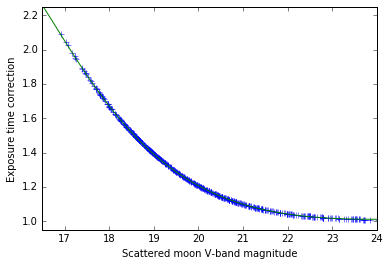

In [63]:
def analyze_moon_study():
    
    model = sklearn.linear_model.LinearRegression(fit_intercept=True)
    getX = lambda x: np.vstack((np.exp(-x),1/x, 1/x**2, 1/x**3)).transpose()
    model.fit(getX(moon_V), factor)
    print model.intercept_, list(model.coef_)

    x_model = np.linspace(16.5, 24, 50)
    y_model = model.predict(getX(x_model))
    
    plt.plot(moon_V, factor, '+')
    plt.plot(x_model, y_model, '-')
    plt.xlabel('Scattered moon V-band magnitude')
    plt.ylabel('Exposure time correction')
    plt.xlim(x_model[0], x_model[-1])
    plt.ylim(0.95, 2.25)
    
analyze_moon_study()

Build a self-contained function that calculates the exposure time correction given input moon parameters:

In [ ]:
def get_moon_correction(moon_phase=0.25, moon_zenith=100*u.deg, moon_separation=60*u.deg):
    
    desi.atmosphere.moon.moon_phase = moon_phase
    desi.atmosphere.moon.moon_zenith = moon_zenith
    desi.atmosphere.moon.separation_angle = moon_separation
    
    x = desi.desi.atmospherepheree.moon.scattered_V
    print x
    return intercept + coefs[0] * np.exp(-x) + coefs[1] / x + coefs[2] / x ** 2

Study the scaling of SNR with exposure time:

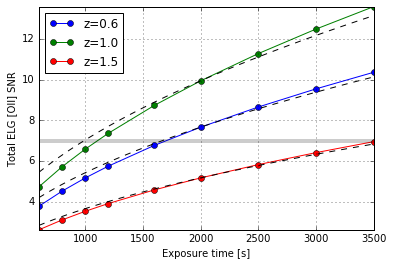

In [41]:
def snr_vs_texp(iscale=5, simulator=desi, save=None):
    zvec = (0.6, 1.0, 1.5)
    tvec = (600, 800, 1000, 1200, 1600, 2000, 2500, 3000, 3500)
    # Calculate sqrt(t) scaling relative to tvec[iscale]
    tscale = np.linspace(600, 3500, 100)
    sfac = np.sqrt(tscale / tvec[iscale])
    snrtot = np.empty((len(zvec), len(tvec)))
    for i, z in enumerate(zvec):
        for j, t in enumerate(tvec):
            snrtot[i, j] = simulate_elg(z, exposure_time=t * u.s, simulator=simulator)
        plt.plot(tvec, snrtot[i], '-o', label='z={:.1f}'.format(z))
        # Use sqrt(t) scaling of the 1000s point.
        plt.plot(tscale, snrtot[i, iscale] * sfac, 'k--')
    plt.legend(loc='upper left')
    plt.xlim(tvec[0], tvec[-1])
    plt.ylim(np.min(snrtot), np.max(snrtot))
    plt.grid()
    plt.axhline(7, lw=4, alpha=0.2, color='k')
    plt.xlabel('Exposure time [s]')
    plt.ylabel('Total ELG [OII] SNR')
    if save:
        plt.savefig(save)
    
snr_vs_texp(save='texp_scaling.pdf')

Check that the scaling violations are due to read noise by creating an alternative simulator with read noises set to zero.

In [33]:
import specsim.config
desi_alt_config = specsim.config.load_config('desi')

In [34]:
desi_alt_config.instrument.cameras.b.constants.read_noise = '0 electron/pixel2'
desi_alt_config.instrument.cameras.r.constants.read_noise = '0 electron/pixel2'
desi_alt_config.instrument.cameras.z.constants.read_noise = '0 electron/pixel2'

In [35]:
desi_alt = specsim.simulator.Simulator(desi_alt_config)

In [37]:
desi_alt.source.update_in(
    'ELG [OII] doublet', 'elg',
    elg_wlen0 * u.Angstrom, elg_flux0 * u.erg/(u.cm**2 * u.s * u.Angstrom), z_in=0.)

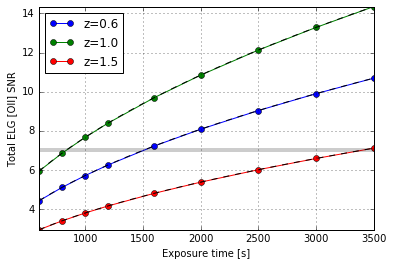

In [42]:
snr_vs_texp(simulator=desi_alt, save='texp_scaling_alt.pdf')

Study the scaling with airmass:

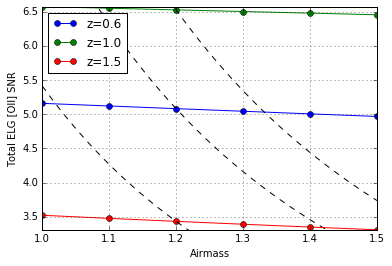

In [118]:
def snr_vs_airmass(iscale=2):
    zvec = (0.6, 1.0, 1.5)
    Xvec = np.linspace(1., 1.5, 6)
    # Calculate X**-2.5 scaling relative to Xvec[iscale]
    Xscale = np.linspace(1.,1.5, 100)
    sfac = (Xscale / Xvec[iscale]) ** -2.5
    snrtot = np.empty((len(zvec), len(Xvec)))
    for i, z in enumerate(zvec):
        for j, X in enumerate(Xvec):
            snrtot[i, j] = simulate_elg(z, airmass=X)
        plt.plot(Xvec, snrtot[i], '-o', label='z={:.1f}'.format(z))
        plt.plot(Xscale, snrtot[i, iscale] * sfac, 'k--')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.legend(loc='upper left')
    plt.xlim(Xvec[0], Xvec[-1])
    plt.ylim(np.min(snrtot), np.max(snrtot))
    plt.grid()
    plt.axhline(7, lw=4, alpha=0.2, color='k')
    plt.xlabel('Airmass')
    plt.ylabel('Total ELG [OII] SNR')
    
snr_vs_airmass()